<a href="https://colab.research.google.com/github/nessamariano/deliverable-01-dnc-dataset-king-/blob/main/roof_imoveis_deliverable_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deliverable 01

Dataset: King Count - Roof Imóveis





Instalando as bibliotecas de geolocalização e visualização de dados





In [3]:
#!pip install uszipcode # será utilizada para descobrirmos as cidades
#!pip install folium # será utilizada para plotar dos dados no mapa
#!pip install plotly.express # será utilizada para gráficos

Importando as bibliotecas





In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import scipy.stats as stats

import folium as folium

from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr
from uszipcode import SearchEngine

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Lendo o arquivo

In [89]:
file_name = 'https://raw.githubusercontent.com/nessamariano/deliverable-01-dnc-dataset-king-/main/kc_house_data.csv'
roof = pd.read_csv(file_name)
roof.shape

(21613, 21)

O arquivo possui 21.613 linhas e 21 colunas

In [6]:
roof.head() # exibindo as 5 primeiras linhas e conhecendo o dataset

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

Entendendo o que significa cada variável

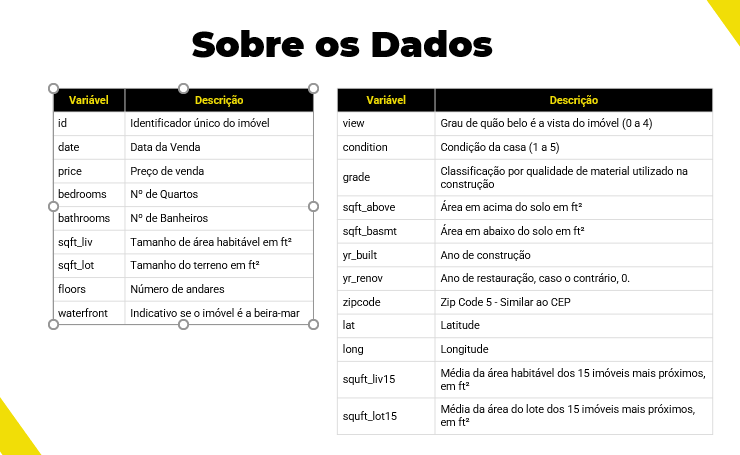

Levantando informações sobre dados nulos e tipos de variáveis

In [7]:
roof.info() #ou roof.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Verificações:



*   a variável 'date' está como object, precisamos transformá-la em datetime. 
*   a variável 'bathroom' está no formato float, precisamos entender o motivo dessa variável não estar do tipo 'int'.
*   algumas variáveis no dataset estão na unidade de medida ft², vamos transformá-las em m².
*   não precisaremos tratar dados nulos e nem ausentes.




Tratamento das variáveis

In [8]:
# Data
#Vamos primeiro eliminar a letra T
roof['date'] = roof['date'].apply(lambda x : x.split('T')[0])

#Agora vamos colocar hífen
roof['date'] = roof['date'].apply(lambda x : f'{x[0:4]}-{x[4:6]}-{x[6:]}')

#Por fim, vamos transformá-la em datetime
roof['date'] = pd.to_datetime(roof['date']) 

#Vamos aproveitar e arredondar a coluna 'price'
roof['price'] = roof['price'].round(0)


Transformando as variáveis de ft² para m², para melhor entendimento

In [9]:
#tratar as áreas em ft² para m²
roof[['sqft_living', 'sqft_lot',
     'sqft_above', 'sqft_basement', 'sqft_living15', 
     'sqft_lot15']] = roof[['sqft_living', 'sqft_lot',
                          'sqft_above', 'sqft_basement', 
                          'sqft_living15', 'sqft_lot15']] .apply(lambda x : x /10.764)



Após pesquisa sobre tipos de imóveis nos USA, identificamos que eles consideram lavabos ou locais que tem somente pia como banheiros. Por essa razão o dataset apresenta valores quebrados para variável 'bathroom'. 




Vamos desconsiderar essa informação adicional e iremos tratar a variável para que seja do tipo 'int' e facilite na exploração dos dados.

In [10]:
#tratar float

roof[['bathrooms', 'floors', 
      'sqft_living', 'sqft_lot',
     'sqft_above', 'sqft_basement', 
      'sqft_living15', 'sqft_lot15']] = roof[['bathrooms', 'floors', 
                                              'sqft_living', 'sqft_lot','sqft_above', 
                                              'sqft_basement', 'sqft_living15', 'sqft_lot15']].astype(int)

roof.info()#verificando se foi feita a alteração.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  int64         
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  int64         
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

Para melhor entendimento do dataset, vamos criar a variável de valor_m², que irá balizar algumas decisões mais a frente.

Utilizaremos como base a área habitacional.

In [11]:
roof['valor_m²'] = (roof.price/roof.sqft_living).round(0)

Para descobrir onde os imóveis estão localizados, utilizaremos a biblioteca Uszipcode, que retornará a cidade através da coluna 'zipcode'.

Para obtermos esse resultado, será feito um loop no dataset e posterior criação da coluna 'city' com a informação.



In [12]:
engine = SearchEngine()
for index, row in roof.iterrows():
  zipcode = engine.by_zipcode(roof['zipcode'][index])
  roof['city'] = zipcode.major_city

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [13]:
roof.head()#verificando se a coluna foi criada

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3          1          109   
1  6414100192 2014-12-09  538000.0         3          2          238   
2  5631500400 2015-02-25  180000.0         2          1           71   
3  2487200875 2014-12-09  604000.0         4          3          182   
4  1954400510 2015-02-18  510000.0         3          2          156   

   sqft_lot  floors  waterfront  view  ...  sqft_basement  yr_built  \
0       524       1           0     0  ...              0      1955   
1       672       2           0     0  ...             37      1951   
2       929       1           0     0  ...              0      1933   
3       464       1           0     0  ...             84      1965   
4       750       1           0     0  ...              0      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0             0    98178  47.5112 -122.257            124         524   
1          1991    98125  47.7210 -122.319            157         709   
2             0    98028  47.7379 -122.233            252         748   
3             0    98136  47.5208 -122.393            126         464   
4             0    98074  47.6168 -122.045            167         697   

   valor_m²     city  
0    2036.0  Seattle  
1    2261.0  Seattle  
2    2535.0  Seattle  
3    3319.0  Seattle  
4    3269.0  Seattle  

[5 rows x 23 columns]

Para melhor entendimento das variáveis, iremos renomear as colunas para português.

In [14]:
#Mudar nome de colunas
roof = roof.rename(columns = {'date': 'data',
                              'price': 'preço_em_dolar',
                              'bedrooms' : 'quartos',
                              'bathrooms' : 'banheiros',
                              'sqft_living' : 'area_habitavel_m²',
                              'sqft_lot' : 'terreno_m²',
                              'floors' : 'num_andares',
                              'waterfront' : 'beira-mar',
                              'view' : 'vista',
                              'condition' : 'condicao_da_casa',
                              'grade': 'qualidade material_de_contrucao',
                              'sqft_above' : 'area_acima_solo_m²',
                              'sqft_basement' : 'area_abaixo_solo_m²',
                              'yr_built' : 'ano_construção',
                              'yr_renovated': 'ano_restauração',
                              'zipcode' : 'zipcode',
                              'lat' : 'latitude',
                              'long' : 'longitude',
                              'sqft_living15' : 'media_area_habitavel_região_m²',
                              'sqft_lot15' : 'media_area_lote_região_m²',
                              'valor_m²' : 'valor_m²',
                              'city': 'cidade'})


Vamos alterar o índice para data, e isso nos ajudará a identificar mais a frente as linhas duplicadas.

In [15]:
roof.set_index('data', inplace=True)


Duplicadas

Verificando a ocorrência de linhas duplicadas no dataset

In [16]:
roof.value_counts('id') #ok! temos 'ids' que apresentam mais de uma ocorrência no dataset, isso siginifica 
#que a casa foi vendida mais de uma vez no período.

id
795000620     3
1000102       2
3578401060    2
3528000040    2
4345000510    2
             ..
2768000295    1
2768000270    1
2767900355    1
2767800140    1
9900000190    1
Length: 21436, dtype: int64

Vamos criar uma variável que irá armazenas todas as linhas do dataset que estão duplicadas.


Conseguimos essa informação, pois utilizamos o parâmetro keep=False.

São 353 linhas.

In [17]:
roof_dupli = roof[roof.duplicated(subset='id', keep=False)]
roof_dupli

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-07-25  6021501535        430000.0        3          1                146   
2014-12-23  6021501535        700000.0        3          1                146   
2014-06-18  4139480200       1384000.0        4          3                398   
2014-12-09  4139480200       1400000.0        4          3                398   
2014-09-05  7520000520        232000.0        2          1                115   
...                ...             ...      ...        ...                ...   
2015-03-30  8564860270        502000.0        4          2                248   
2014-06-26  6300000226        240000.0        4          1                111   
2015-05-04  6300000226        380000.0        4          1                111   
2014-10-03  7853420110        594866.0        3          3                258   
2015-05-04  7853420110        625000.0        3          3                258   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-07-25         464            1          0      0                 3  ...   
2014-12-23         464            1          0      0                 3  ...   
2014-06-18        1124            1          0      3                 3  ...   
2014-12-09        1124            1          0      3                 3  ...   
2014-09-05        1123            1          0      0                 3  ...   
...                ...          ...        ...    ...               ...  ...   
2015-03-30         514            2          0      0                 3  ...   
2014-06-26         201            1          0      0                 3  ...   
2015-05-04         201            1          0      0                 3  ...   
2014-10-03         557            2          0      0                 3  ...   
2015-05-04         557            2          0      0                 3  ...   

            area_abaixo_solo_m²  ano_construção  ano_restauração  zipcode  \
data                                                                        
2014-07-25                   26            1939                0    98117   
2014-12-23                   26            1939                0    98117   
2014-06-18                  148            1997                0    98006   
2014-12-09                  148            1997                0    98006   
2014-09-05                   26            1922             1984    98146   
...                         ...             ...              ...      ...   
2015-03-30                    0            2013                0    98045   
2014-06-26                    0            1933                0    98133   
2015-05-04                    0            1933                0    98133   
2014-10-03                    0            2013                0    98065   
2015-05-04                    0            2013                0    98065   

            latitude  longitude  media_area_habitavel_região_m²  \
data                                                              
2014-07-25   47.6870   -122.386                             145   
2014-12-23   47.6870   -122.386                             145   
2014-06-18   47.5503   -122.102                             358   
2014-12-09   47.5503   -122.102                             358   
2014-09-05   47.4957   -122.352                             169   
...              ...        ...                             ...   
2015-03-30   47.4759   -121.734                             248   
2014-06-26   47.7076   -122.342                             104   
2015-05-04   47.7076   -122.342                             104   
2014-10-03   47.5184   -121.886                             264   
2015-05-04   47.5184   -121.886                             264   

            media_area_lote_região_m²  valor_m²   c

Como percebemos, alguns imóveis foram vendidos mais de uma vez nesse período de tempo, e podemos levantar a informação sobre a rentabilidade dessas vendas.

Para isso, vamos criar 2 datasets. 
O primeiro constará a primeira venda no dataset e o segundo constará a segunda venda no dataset.
Utilizaremos os parâmetros 'first' e 'last'.


Vamos renomear a coluna preço de cada dataset, para conseguirmos distinguí-los logo a frente.

In [18]:
rf1 = roof_dupli[roof_dupli.duplicated(subset='id', keep='last')]

In [19]:
rf1.rename(columns={'preço_em_dolar': 'preço_x'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
rf2 = roof_dupli[roof_dupli.duplicated(subset='id', keep='first')]

In [21]:
rf2.rename(columns={'preço_em_dolar': 'preço_y'}, inplace=True)

Agora vamos fazer a junção desse dataset via 'id'.

In [22]:
roof_var = pd.merge(rf1,rf2, on='id')

Mostrando as colunas 'id', 'preço (x e y)'.

Assim visualizamos os 2 preços que os imóveis foram vendidos, sendo Y o último preço e X, o primeiro preço.

In [23]:
roof_var = roof_var.loc[:,['id', 'preço_y', 'preço_x', 'latitude_x', 'longitude_x']]
roof_var

id    preço_y    preço_x  latitude_x  longitude_x
0    6021501535   700000.0   430000.0     47.6870     -122.386
1    4139480200  1400000.0  1384000.0     47.5503     -122.102
2    7520000520   240500.0   232000.0     47.4957     -122.352
3    3969300030   239900.0   165000.0     47.4897     -122.240
4    2231500030   530000.0   315000.0     47.7711     -122.341
..          ...        ...        ...         ...          ...
174  7853400250   645000.0   610000.0     47.5168     -121.883
175  2724049222   220000.0   163800.0     47.5419     -122.271
176  8564860270   502000.0   449990.0     47.4759     -121.734
177  6300000226   380000.0   240000.0     47.7076     -122.342
178  7853420110   625000.0   594866.0     47.5184     -121.886

[179 rows x 5 columns]

Agora conseguimos criar a coluna 'lucro_preju', que mostrará a porcentagem de lucro ou prejuízo na venda.

In [24]:
roof_var['lucro_preju'] = (roof_var['preço_y']/roof_var['preço_x']-1)*100 
roof_var.head().round(1)

id    preço_y    preço_x  latitude_x  longitude_x  lucro_preju
0  6021501535   700000.0   430000.0        47.7       -122.4         62.8
1  4139480200  1400000.0  1384000.0        47.6       -122.1          1.2
2  7520000520   240500.0   232000.0        47.5       -122.4          3.7
3  3969300030   239900.0   165000.0        47.5       -122.2         45.4
4  2231500030   530000.0   315000.0        47.8       -122.3         68.3

Ordenando a coluna 'lucro_preju' para identificarmos as maiores porcentagens de lucro.

In [25]:
roof_var.sort_values('lucro_preju', ascending=False)

id    preço_y    preço_x  latitude_x  longitude_x  lucro_preju
120  2023049218   445000.0   105500.0     47.4611     -122.324   321.800948
145  7129304540   440000.0   133000.0     47.5192     -122.266   230.827068
127  3333002450   490000.0   165000.0     47.5427     -122.288   196.969697
87   2422049104   235000.0    85000.0     47.3813     -122.243   176.470588
63   3883800011   219900.0    82000.0     47.4987     -122.341   168.170732
..          ...        ...        ...         ...          ...          ...
59   4139420590  1200000.0  1212500.0     47.5521     -122.115    -1.030928
91   2767603612   489000.0   500000.0     47.6719     -122.382    -2.200000
7    8682262400   419950.0   430000.0     47.7176     -122.033    -2.337209
42   2726049071   489950.0   510000.0     47.7076     -122.284    -3.931373
118  7167000040   700000.0   740000.0     47.3602     -121.988    -5.405405

[179 rows x 6 columns]

Ok! Tivemos imóveis com lucros acima de 300% e imóveis que foram vendidos abaixo do preço de compra.

Mas será que todos esses imóveis seguiram essas rentabilidades?

Para identificarmos essa distribuição, iremos plotar o gráfico boxplot.

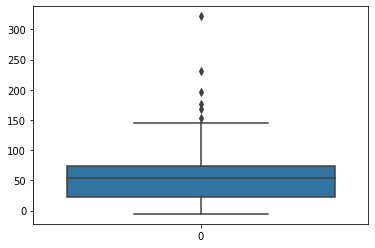

In [26]:
sns.boxplot(data=roof_var['lucro_preju']); #matplotlib

In [27]:
px.box(data_frame=roof_var.reset_index(), y='lucro_preju') #ploty.express

Como podemos perceber 75% dos resultados foram negociados com uma margem de até 73%(Q3), sendo o mínimo negociado a -5.40%.

A mediana das negociações ficou em 54%.

Plotaremos no gráfico abaixo para visualização da localização desses imóveis.

In [28]:
roofvar_map = folium.Map(location=(47.7711, -122.341), zoom_start=11)
for index,row in roof_var.iterrows(): 
  folium.Marker(location=(row['latitude_x'], 
                          row['longitude_x']), 
                popup=row['id']).add_to(roofvar_map)

display(roofvar_map)

Guardaremos essa informação sobre os imóveis que foram vendidos mais de uma vez e suas localizações e usaremos mais a frente.

Agora vamos explorar todo dataset e tentar encontrar alguns parâmetros que nos ajude a selecionar os ímoveis.


Para isso, vamos buscar informações de média, mínimo e máximo das variáveis e  suas distribuições e correlações. Dessa forma, podermos identificar outliers que influenciam na média geral e as variáveis que estão influenciando no preço.


In [29]:
roof.describe().T


count          mean           std  \
id                               21613.0  4.580302e+09  2.876566e+09   
preço_em_dolar                   21613.0  5.400881e+05  3.671272e+05   
quartos                          21613.0  3.370842e+00  9.300618e-01   
banheiros                        21613.0  1.749734e+00  7.348731e-01   
area_habitavel_m²                21613.0  1.927266e+02  8.532821e+01   
terreno_m²                       21613.0  1.402966e+03  3.848061e+03   
num_andares                      21613.0  1.446213e+00  5.518935e-01   
beira-mar                        21613.0  7.541757e-03  8.651720e-02   
vista                            21613.0  2.343034e-01  7.663176e-01   
condicao_da_casa                 21613.0  3.409430e+00  6.507430e-01   
qualidade material_de_contrucao  21613.0  7.656873e+00  1.175459e+00   
area_acima_solo_m²               21613.0  1.656391e+02  7.693694e+01   
area_abaixo_solo_m²              21613.0  2.688956e+01  4.091776e+01   
ano_construção                   21613.0  1.971005e+03  2.937341e+01   
ano_restauração                  21613.0  8.440226e+01  4.016792e+02   
zipcode                          21613.0  9.807794e+04  5.350503e+01   
latitude                         21613.0  4.756005e+01  1.385637e-01   
longitude                        21613.0 -1.222139e+02  1.408283e-01   
media_area_habitavel_região_m²   21613.0  1.840545e+02  6.367853e+01   
media_area_lote_região_m²        21613.0  1.185713e+03  2.536623e+03   
valor_m²                         21613.0  2.852702e+03  1.189867e+03   

                                          min           25%           50%  \
id                               1.000102e+06  2.123049e+09  3.904930e+09   
preço_em_dolar                   7.500000e+04  3.219500e+05  4.500000e+05   
quartos                          0.000000e+00  3.000000e+00  3.000000e+00   
banheiros                        0.000000e+00  1.000000e+00  2.000000e+00   
area_habitavel_m²                2.600000e+01  1.320000e+02  1.770000e+02   
terreno_m²                       4.800000e+01  4.680000e+02  7.070000e+02   
num_andares                      1.000000e+00  1.000000e+00  1.000000e+00   
beira-mar                        0.000000e+00  0.000000e+00  0.000000e+00   
vista                            0.000000e+00  0.000000e+00  0.000000e+00   
condicao_da_casa                 1.000000e+00  3.000000e+00  3.000000e+00   
qualidade material_de_contrucao  1.000000e+00  7.000000e+00  7.000000e+00   
area_acima_solo_m²               2.600000e+01  1.100000e+02  1.440000e+02   
area_abaixo_solo_m²              0.000000e+00  0.000000e+00  0.000000e+00   
ano_construção                   1.900000e+03  1.951000e+03  1.975000e+03   
ano_restauração                  0.000000e+00  0.000000e+00  0.000000e+00   
zipcode                          9.800100e+04  9.803300e+04  9.806500e+04   
latitude                         4.715590e+01  4.747100e+01  4.757180e+01   
longitude                       -1.225190e+02 -1.223280e+02 -1.222300e+02   
media_area_habitavel_região_m²   3.700000e+01  1.380000e+02  1.700000e+02   
media_area_lote_região_m²        6.000000e+01  4.730000e+02  7.070000e+02   
valor_m²                         9.450000e+02  1.969000e+03  2.640000e+03   

                                          75%           max  
id                               7.308900e+09  9.900000e+09  
preço_em_dolar                   6.450000e+05  7.700000e+06  
quartos                          4.000000e+00  3.300000e+01  
banheiros                        2.000000e+00  8.000000e+00  
area_habitavel_m²                2.360000e+02  1.257000e+03  
terreno_m²                       9.920000e+02  1.534140e+05  
num_andares                      2.000000e+00  3.000000e+00  
beira-mar                        0.000000e+00  1.000000e+00  
vista                            0.000000e+00  4.000000e+00  
condicao_da_casa                 4.000000e+00  5.000000e+00  
qualidade material_de_contrucao  8.000000e+00  1.300000e+01  
area_acima_

Ok! Temos o indício de alguns outliers.

Na coluna 'máx' temos imóveis com 33 quartos e 8 banheiros, muito acima da média do dataset.

Precisaremos identificar esses outliers e excluí-los do dataset, pois usaremos os valores médios para filtramos nossas indicações.

Ou seja, nossa estratégia será tentar identificar imóveis que são maiores  que os imóveis na média do preço, com o mesmo preço dos imóveis médios.






Como o dataset é grande, vamos criar duas variaveis que irão nos ajudar a olhar de uma maneira mais fácil.

A variável 'roof1' receberá as variáveis numéricas do dataset e a variável 'roof2' receberá as variáveis categóricas.


Visualizando outliers

In [30]:
roof1 = roof[['preço_em_dolar','quartos','banheiros','area_habitavel_m²','terreno_m²','num_andares']]
roof2 = roof[['preço_em_dolar','beira-mar',	'vista',	'condicao_da_casa','qualidade material_de_contrucao', 'ano_construção',	'ano_restauração']]

Usando o histograma para visualizar a distribuição

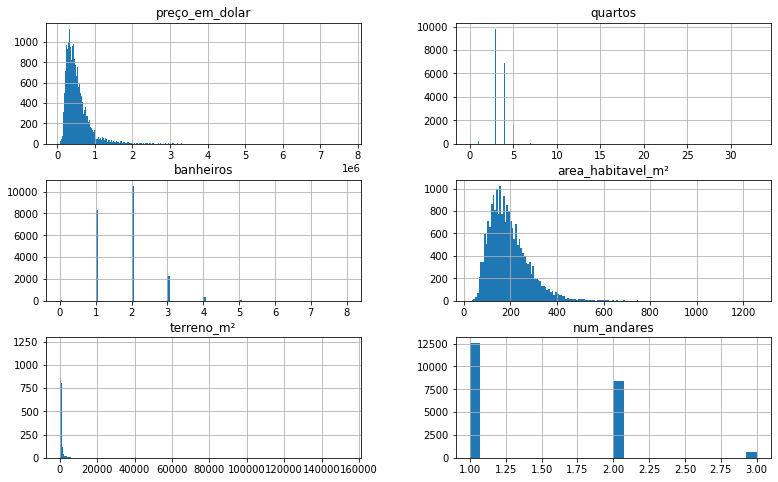

In [31]:
roof1.hist(bins = "auto", figsize = (13,8));

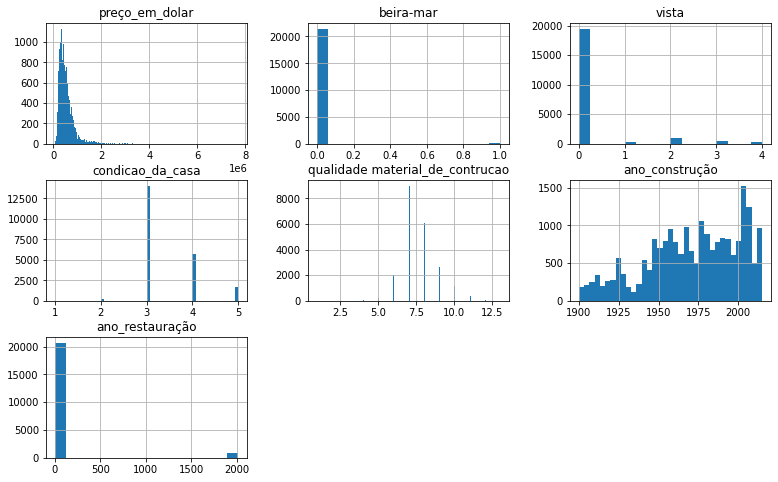

In [32]:
roof2.hist(bins = "auto", figsize = (13,8));

Vamos olhar mais de perto as variáveis numéricas:



*   Preço em Dólar
Área Habitável em m²

*   Área Habitável em m²
*   Item da lista


*   Quartos
*   Banheiros







In [33]:
px.box(data_frame=roof1.reset_index(), y='preço_em_dolar')

# Aqui temos outliers, mais de 75% do dataset encontra-se em níveis de preços até U$645 mil dólares 
#e temos casas que foram negociada a mais de U$7 milhoões.

In [34]:
px.box(data_frame=roof1.reset_index(), y='area_habitavel_m²')

#Aqui temos que 75%  do dataset são de imóveis até 236 m² e temos no dataset imóveis com mais de 1000 m².

In [35]:
px.box(data_frame=roof1.reset_index(), y='banheiros')

# Aqui temos a mediana e Q3, ou seja 75% do dataset com 2 banheiros e imóveis com 8 banheiros.

In [36]:
px.box(data_frame=roof1.reset_index(), y='quartos')

# 75% do dataset são imóveis com até 4 quartos, mas temos imóveis com 33 quartos.

Excluindo os oultiers 

Conceitualmente os outliers são valores 1.5 x maiores que IQR (Q3-Q1).

Assim, vamos encontrar esse limite superior e os valores acima serão considerados outliers.

In [37]:
#Aplicando a identificação de outlier de Tukey
pd.options.display.float_format = '{:.2f}'.format
X_df = pd.DataFrame(roof1)
sumario = X_df.describe()
print(sumario)

       preço_em_dolar  quartos  banheiros  area_habitavel_m²  terreno_m²  \
count        21613.00 21613.00   21613.00           21613.00    21613.00   
mean        540088.14     3.37       1.75             192.73     1402.97   
std         367127.20     0.93       0.73              85.33     3848.06   
min          75000.00     0.00       0.00              26.00       48.00   
25%         321950.00     3.00       1.00             132.00      468.00   
50%         450000.00     3.00       2.00             177.00      707.00   
75%         645000.00     4.00       2.00             236.00      992.00   
max        7700000.00    33.00       8.00            1257.00   153414.00   

       num_andares  
count     21613.00  
mean          1.45  
std           0.55  
min           1.00  
25%           1.00  
50%           1.00  
75%           2.00  
max           3.00  


In [38]:
#Calculando IQR (Q3-Q1)
iqr = sumario.loc['75%'] - sumario.loc['25%']
iqr

preço_em_dolar      323050.00
quartos                  1.00
banheiros                1.00
area_habitavel_m²      104.00
terreno_m²             524.00
num_andares              1.00
dtype: float64

In [39]:
#Identificando outliers abaixo do mínimo
limite_inf = sumario.loc['25%'] - iqr * 1.5 
limite_inf

preço_em_dolar      -162625.00
quartos                   1.50
banheiros                -0.50
area_habitavel_m²       -24.00
terreno_m²             -318.00
num_andares              -0.50
dtype: float64

In [40]:
#Identificando outliers acima 
limite_sup = sumario.loc['75%'] + iqr * 1.5 
limite_sup

preço_em_dolar      1129575.00
quartos                   5.50
banheiros                 3.50
area_habitavel_m²       392.00
terreno_m²             1778.00
num_andares               3.50
dtype: float64

Excluindo os outliers

Vou criar uma variavél roof5_n para termos o dataframe com os outliers e depois fazermos a análise dos imóveis para não comprar.

In [41]:
roof5_n = roof

Procedendo para excluir os ouliers

In [42]:
roof.shape #Dataframe original

(21613, 22)

In [43]:
#excluir valores acima de 1129575.00
roof_clean = roof.loc[(roof['preço_em_dolar'] < 1129575.00 )]
roof_clean.shape #excluimos 1146 registros

(20467, 22)

In [44]:
#excluir valores acima de 392
roof_clean = roof_clean.loc[(roof_clean['area_habitavel_m²'] < 392.00 )]
roof_clean.shape #excluimos 186 registros

(20281, 22)

In [45]:
#excluir valores acima de 3.50
roof_clean = roof_clean.loc[(roof_clean['banheiros'] < 3.50 )]
roof_clean.shape #excluimos 125 registros

(20156, 22)

In [46]:
#excluir valores acima de 5.50
roof_clean = roof_clean.loc[(roof_clean['quartos'] < 5.50 )]
roof_clean.shape #excluimos 217 registros

(19939, 22)

In [47]:
#excluir valores acima de 3.50
roof_clean = roof_clean.loc[(roof_clean['num_andares'] < 3.50 )]
roof_clean.shape #excluimos 0 registros

(19939, 22)

In [48]:
#excluir valores acima de 1778.0
roof_clean = roof_clean.loc[(roof_clean['terreno_m²'] < 1778.00 )]
roof_clean.shape #excluimos 1997 registros

(17942, 22)

O dataset agora conta com 17.942 registros.
Removemos 3.671 registros identificados como outliers.

Agora vamos visualizar as correlações e aplicar alguns testes.

Visualizando as correlações das variáveis com o preço

In [49]:
#Variáveis numéricas

roof1.corr()

#Maior correlação é area_habitavel_m², seguida por banheiros, quartos, num_andares e terreno.

#Aqui podemos observar que a principal varivável correlacionada é area_habitavel_m²

preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
preço_em_dolar               1.00     0.31       0.51               0.70   
quartos                      0.31     1.00       0.47               0.58   
banheiros                    0.51     0.47       1.00               0.70   
area_habitavel_m²            0.70     0.58       0.70               1.00   
terreno_m²                   0.09     0.03       0.09               0.17   
num_andares                  0.24     0.16       0.48               0.35   

                   terreno_m²  num_andares  
preço_em_dolar           0.09         0.24  
quartos                  0.03         0.16  
banheiros                0.09         0.48  
area_habitavel_m²        0.17         0.35  
terreno_m²               1.00        -0.01  
num_andares             -0.01         1.00

In [50]:
#Variáveis categóricas

roof2.corr()

#Maior correlação é com qualidade material de construção

preço_em_dolar  beira-mar  vista  \
preço_em_dolar                             1.00       0.27   0.40   
beira-mar                                  0.27       1.00   0.40   
vista                                      0.40       0.40   1.00   
condicao_da_casa                           0.04       0.02   0.05   
qualidade material_de_contrucao            0.67       0.08   0.25   
ano_construção                             0.05      -0.03  -0.05   
ano_restauração                            0.13       0.09   0.10   

                                 condicao_da_casa  \
preço_em_dolar                               0.04   
beira-mar                                    0.02   
vista                                        0.05   
condicao_da_casa                             1.00   
qualidade material_de_contrucao             -0.14   
ano_construção                              -0.36   
ano_restauração                             -0.06   

                                 qualidade material_de_contrucao  \
preço_em_dolar                                              0.67   
beira-mar                                                   0.08   
vista                                                       0.25   
condicao_da_casa                                           -0.14   
qualidade material_de_contrucao                             1.00   
ano_construção                                              0.45   
ano_restauração                                             0.01   

                                 ano_construção  ano_restauração  
preço_em_dolar                             0.05             0.13  
beira-mar                                 -0.03             0.09  
vista                                     -0.05             0.10  
condicao_da_casa                          -0.36            -0.06  
qualidade material_de_contrucao            0.45             0.01  
ano_construção                             1.00            -0.22  
ano_restauração                           -0.22             1.00

Plotando o heatmap para identificar visualmente

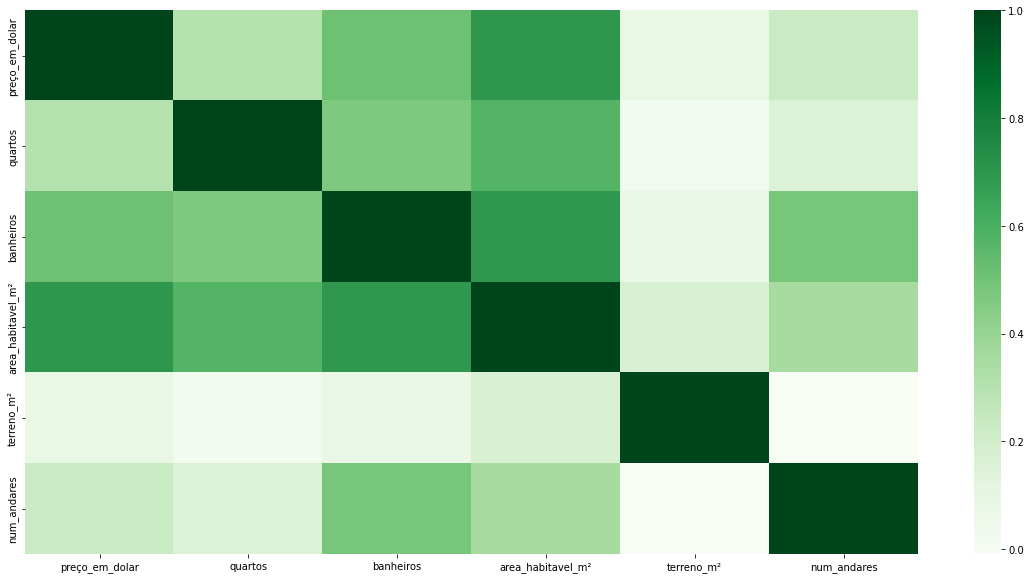

In [51]:
plt.figure(figsize=(20, 10))
sns.heatmap(roof1.corr(), cmap="Greens");


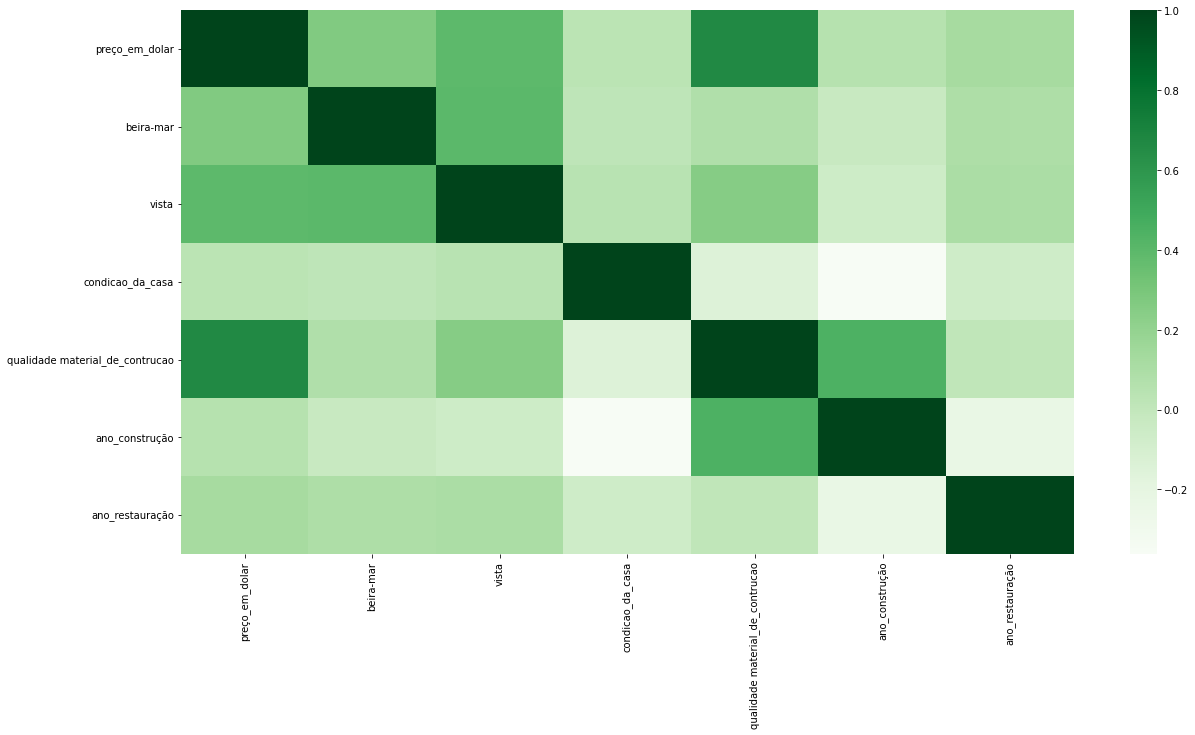

In [52]:
plt.figure(figsize=(20, 10))
sns.heatmap(roof2.corr(), cmap="Greens");

Checando se a correlação é verdadeira

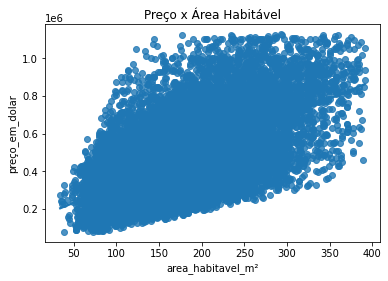

In [53]:
sns.regplot(y=roof_clean['preço_em_dolar'],x=roof_clean['area_habitavel_m²']);
plt.title('Preço x Área Habitável');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [54]:
#Área habitável
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['area_habitavel_m²'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['area_habitavel_m²'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é menor que 0.05, indicando variáveis correlacionadas

PearsonR Correlation Coefficient 0.588
Chi-square Statistic 1.38e+06 p_value 0.0


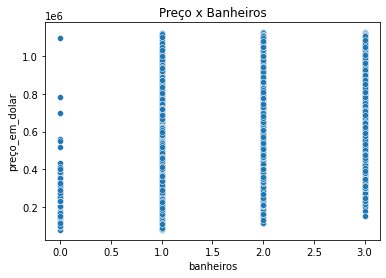

In [55]:
sns.scatterplot(y=roof_clean['preço_em_dolar'],x=roof_clean['banheiros']);
plt.title('Preço x Banheiros');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [56]:
#Banheiros
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['banheiros'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['banheiros'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é maior que 0.05, indicando variáveis independentes

PearsonR Correlation Coefficient 0.362
Chi-square Statistic 1.31e+04 p_value 2.49e-94


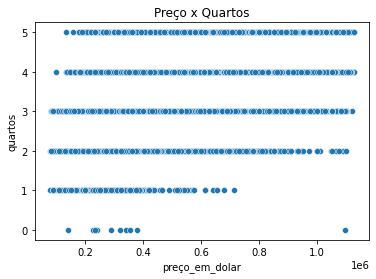

In [57]:
sns.scatterplot(x=roof_clean['preço_em_dolar'],y=roof_clean['quartos']);
plt.title('Preço x Quartos');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [58]:
#Quartos
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['quartos'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['quartos'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é maior que 0.05, indicando variáveis independentes

PearsonR Correlation Coefficient 0.283
Chi-square Statistic 1.84e+04 p_value 3.52e-22


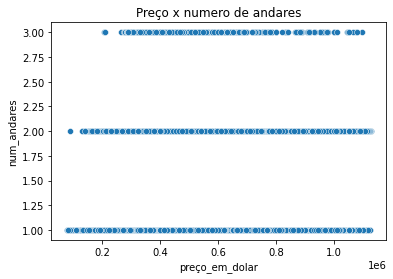

In [59]:
sns.scatterplot(x=roof_clean['preço_em_dolar'],y=roof_clean['num_andares']);
plt.title('Preço x numero de andares');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [60]:
#Número de andares
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['num_andares'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['num_andares'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é maior que 0.05, indicando variáveis independentes

PearsonR Correlation Coefficient 0.223
Chi-square Statistic 7.81e+03 p_value 1.09e-22


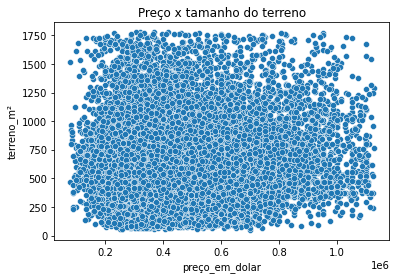

In [61]:
sns.scatterplot(x=roof_clean['preço_em_dolar'],y=roof_clean['terreno_m²']);
plt.title('Preço x tamanho do terreno');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [62]:
#Tamanho do terreno
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['terreno_m²'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['terreno_m²'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é maior que 0.05, indicando variáveis independentes

PearsonR Correlation Coefficient -0.0139
Chi-square Statistic 5.25e+06 p_value 1.0


Variável categórica

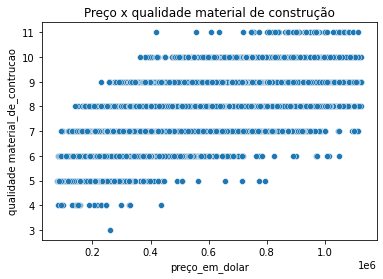

In [63]:
sns.scatterplot(x=roof_clean['preço_em_dolar'],y=roof_clean['qualidade material_de_contrucao']);
plt.title('Preço x qualidade material de construção');

Testes de hipótese para confirmar depois, não é solicitado nesse case.

In [64]:
coeficiente_pearsonr, p_valor = pearsonr(roof_clean['preço_em_dolar'],roof_clean['qualidade material_de_contrucao'] )
print('PearsonR Correlation Coefficient {:0.3}'.format(coeficiente_pearsonr))

coeficiente_spearmanr, p_valor = spearmanr(roof_clean['preço_em_dolar'],roof_clean['qualidade material_de_contrucao'])
print('Spearman Rank Correlation Coefficient {:0.3}'.format(coeficiente_spearmanr))

table = pd.crosstab(roof_clean['preço_em_dolar'],roof_clean['qualidade material_de_contrucao'])

from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic {:0.3} p_value {:0.3}'.format(chi2, p))

#P_value é menor que 0.05, indicando variáveis correlacionadas

PearsonR Correlation Coefficient 0.6
Spearman Rank Correlation Coefficient 0.576
Chi-square Statistic 3.92e+04 p_value 0.0


Ou seja, após os testes, as variáveis que se correlacionam com preço são área habitavel e qualidade do material de construção.

#Procederemos para começar a filtrar o dataset em busca dos imóveis a serem indicados, de acordo com  a estratégia.

In [65]:
roof_clean.describe()

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
count      17942.00        17942.00 17942.00   17942.00           17942.00   
mean  4751522669.69       462542.46     3.26       1.64             174.34   
std   2869520518.70       201433.31     0.82       0.62              64.34   
min      2800031.00        78000.00     0.00       0.00              34.00   
25%   2313900757.50       306903.50     3.00       1.00             126.00   
50%   4060000265.00       425000.00     3.00       2.00             166.00   
75%   7504400825.00       580000.00     4.00       2.00             215.00   
max   9900000190.00      1127000.00     5.00       3.00             391.00   

       terreno_m²  num_andares  beira-mar    vista  condicao_da_casa  ...  \
count    17942.00     17942.00   17942.00 17942.00          17942.00  ...   
mean       672.11         1.42       0.00     0.15              3.41  ...   
std        328.45         0.55       0.04     0.59              0.65  ...   
min         48.00         1.00       0.00     0.00              1.00  ...   
25%        445.00         1.00       0.00     0.00              3.00  ...   
50%        667.00         1.00       0.00     0.00              3.00  ...   
75%        857.75         2.00       0.00     0.00              4.00  ...   
max       1776.00         3.00       1.00     4.00              5.00  ...   

       area_acima_solo_m²  area_abaixo_solo_m²  ano_construção  \
count            17942.00             17942.00        17942.00   
mean               150.79                23.36         1970.13   
std                 61.31                35.57           29.85   
min                 34.00                 0.00         1900.00   
25%                106.00                 0.00         1950.00   
50%                135.00                 0.00         1972.00   
75%                183.00                46.00         1997.00   
max                391.00               185.00         2015.00   

       ano_restauração  zipcode  latitude  longitude  \
count         17942.00 17942.00  17942.00   17942.00   
mean             70.08 98081.36     47.56    -122.23   
std             367.37    53.98      0.14       0.13   
min               0.00 98001.00     47.16    -122.51   
25%               0.00 98033.00     47.47    -122.34   
50%               0.00 98074.00     47.57    -122.27   
75%               0.00 98118.00     47.68    -122.15   
max            2015.00 98199.00     47.78    -121.31   

       media_area_habitavel_região_m²  media_area_lote_região_m²  valor_m²  
count                        17942.00                   17942.00  17942.00  
mean                           171.95                     674.15   2787.60  
std                             53.05                     405.99   1110.86  
min                             42.00                      60.00    945.00  
25%                            133.00                     460.00   1935.00  
50%                            162.00                     668.00   2618.50  
75%                            202.00                     830.00   3382.00  
max                            459.00                   18263.00   8750.00  

[8 rows x 21 columns]

Para facilitar, vamos dividir o dataset em 2 de acordo com o valor do m², vamps fazer um loop no dataset.

#Nossa estratégia é encontrar imóveis maiores com o mesmo preço dos imóveis médios.

Usaremos os targets abaixo.


In [66]:
roof_clean.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



id                                4751522669.69
preço_em_dolar                        462542.46
quartos                                    3.26
banheiros                                  1.64
area_habitavel_m²                        174.34
terreno_m²                               672.11
num_andares                                1.42
beira-mar                                  0.00
vista                                      0.15
condicao_da_casa                           3.41
qualidade material_de_contrucao            7.46
area_acima_solo_m²                       150.79
area_abaixo_solo_m²                       23.36
ano_construção                          1970.13
ano_restauração                           70.08
zipcode                                98081.36
latitude                                  47.56
longitude                               -122.23
media_area_habitavel_região_m²           171.95
media_area_lote_região_m²                674.15
valor_m²                                

In [67]:
parametro = []
for i in roof_clean['valor_m²']:
  if i > 2787.60:
    parametro.append('Acima da média do mercado')
  else:
    parametro.append('Abaixo da média do mercado')  

roof_clean['parametro'] = parametro



Agrupamos os imoveis que estão abaixo e acima da média do mercado.

In [68]:
roof_clean.groupby(by='parametro').mean()


id  preço_em_dolar  quartos  banheiros  \
parametro                                                                      
Abaixo da média do mercado 4729246937.77       379301.44     3.45       1.71   
Acima da média do mercado  4780082753.36       569267.15     3.03       1.55   

                            area_habitavel_m²  terreno_m²  num_andares  \
parametro                                                                
Abaixo da média do mercado             188.19      740.53         1.44   
Acima da média do mercado              156.58      584.39         1.40   

                            beira-mar  vista  condicao_da_casa  ...  \
parametro                                                       ...   
Abaixo da média do mercado       0.00   0.10              3.35  ...   
Acima da média do mercado        0.00   0.22              3.48  ...   

                            area_acima_solo_m²  area_abaixo_solo_m²  \
parametro                                                             
Abaixo da média do mercado              163.10                24.90   
Acima da média do mercado               134.99                21.39   

                            ano_construção  ano_restauração  zipcode  \
parametro                                                              
Abaixo da média do mercado         1977.10            48.84 98072.84   
Acima da média do mercado          1961.19            97.31 98092.27   

                            latitude  longitude  \
parametro                                         
Abaixo da média do mercado     47.50    -122.20   
Acima da média do mercado      47.63    -122.26   

                            media_area_habitavel_região_m²  \
parametro                                                    
Abaixo da média do mercado                          177.27   
Acima da média do mercado                           165.14   

                            media_area_lote_região_m²  valor_m²  
parametro                                                        
Abaixo da média do mercado                     738.91   2020.39  
Acima da média do mercado                      591.11   3771.26  

[2 rows x 21 columns]

Filtrando apenas os imóveis que estão abaixo dessa media do mercado

In [69]:
clean = roof_clean.loc[roof_clean['parametro'] == 'Abaixo da média do mercado']
clean.shape


(10080, 23)

#São 10.080 imóveis que estão abaixo da média do mercado.
Agora vamos vasculhar esse dataset e encontrar casas maiores que a média, mas no preço das casas médias.

As variáveis que se correlacionam com os preços conforme vimos são área habitavel e qualidade de material de construção.

De acordo com os valores médios temos:


preço_em_dolar =                          462542.46

quartos    =                                3.26

banheiros  =                                1.64

area_habitavel_m²    =                    174.34

terreno_m²     =                          672.11

num_andares  =                              1.42


qualidade material_de_contrucao   =         7.46

media_area_habitavel_região_m² =          171.95

media_area_lote_região_m²   =             674.15

valor_m²           =                     2787.60



#De acordo com as maiores correlações, vamos levar em questão a área habitável e a qualidade do material de construção.

In [70]:
c1 = roof_clean.loc[((roof_clean['preço_em_dolar'] < 462542.0) & (roof_clean['area_habitavel_m²'] > 174) & (roof_clean['qualidade material_de_contrucao'] > 7.46))]

In [71]:
c1.shape

(1457, 23)

São 1457 registros com preços menores que a média e com área habitável maior que a média e qualidade do material de construção melhor que a média.

Vamos plotar no gráfico para localizar esses imóveis.

In [72]:
c1_map = folium.Map(location=(47.4034, -122.167), zoom_start=10)
for index,row in c1.iterrows(): 
  folium.Marker(location=(row['latitude'], 
                          row['longitude']), 
                popup=row['id']).add_to(c1_map)

display(c1_map)

Lembra dos imóveis que tinham sido vendidos mais que uam vez, vamos fazer uma verificação agora.

Será que esses imóveis estão dentro desse filtro que chegamos agora?

vamos fazer um merge no dataset, mas uma intersecção, para termos somente os ID's em comum.

In [73]:
roof_verif = pd.merge(c1,roof_var, how='inner', on='id')
roof_verif

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
0   7524400250       424240.00        3          2                193   
1   3578401060       345000.00        3          2                178   
2   1954420170       368250.00        3          2                199   
3   8651510380       310000.00        3          2                192   
4    251300110       225000.00        3          2                233   
5    251300110       358000.00        3          2                233   
6   1139600270       300000.00        3          2                194   
7   1139600270       310000.00        3          2                194   
8   6143000020       175000.00        3          1                177   
9   6143000020       299000.00        3          1                177   
10  1974300020       380000.00        4          2                210   
11  8564860270       449990.00        4          2                248   

    terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
0         1123            2          0      0                 4  ...   
1          898            2          0      0                 4  ...   
2          695            2          0      0                 3  ...   
3          854            1          0      0                 3  ...   
4         1116            2          0      0                 3  ...   
5         1116            2          0      0                 3  ...   
6          893            1          0      0                 3  ...   
7          893            1          0      0                 3  ...   
8         1579            1          0      0                 4  ...   
9         1579            1          0      0                 4  ...   
10        1068            1          0      0                 3  ...   
11         514            2          0      0                 3  ...   

    media_area_habitavel_região_m²  media_area_lote_região_m²  valor_m²  \
0                              207                       1133   2198.00   
1                              181                        940   1938.00   
2                              199                        639   1851.00   
3                              193                        887   1615.00   
4                              173                        744    966.00   
5                              173                        744   1536.00   
6                              199                        897   1546.00   
7                              199                        897   1598.00   
8                              169                       1375    989.00   
9                              169                       1375   1689.00   
10                             187                       1014   1810.00   
11                             248                        556   1814.00   

     cidade                   parametro   preço_y   preço_x  latitude_x  \
0   Seattle  Abaixo da média do mercado 589950.00 424240.00       47.70   
1   Seattle  Abaixo da média do mercado 625000.00 345000.00       47.62   
2   Seattle  Abaixo da média do mercado 580000.00 368250.00       47.62   
3   Seattle  Abaixo da média do mercado 539000.00 310000.00       47.65   
4   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
5   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
6   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   
7   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   
8   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   
9   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   
10  Seattle  Abaixo da média do mercado 624900.00 380000.00       47.71   
11  Seattle  Abaixo da média do mercado 502000.00 449990.00       47.48   

    longitude_x  lucro_preju  
0       -122.16        39.06  
1       -122.05        81.16  
2       -122.04        57.50  
3       -122.06        73.87  
4       -122.31   

In [74]:
roof_verif = roof_verif.sort_values(by='media_area_habitavel_região_m²', ascending=False)
roof_verif

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
11  8564860270       449990.00        4          2                248   
0   7524400250       424240.00        3          2                193   
2   1954420170       368250.00        3          2                199   
6   1139600270       300000.00        3          2                194   
7   1139600270       310000.00        3          2                194   
3   8651510380       310000.00        3          2                192   
10  1974300020       380000.00        4          2                210   
1   3578401060       345000.00        3          2                178   
4    251300110       225000.00        3          2                233   
5    251300110       358000.00        3          2                233   
8   6143000020       175000.00        3          1                177   
9   6143000020       299000.00        3          1                177   

    terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
11         514            2          0      0                 3  ...   
0         1123            2          0      0                 4  ...   
2          695            2          0      0                 3  ...   
6          893            1          0      0                 3  ...   
7          893            1          0      0                 3  ...   
3          854            1          0      0                 3  ...   
10        1068            1          0      0                 3  ...   
1          898            2          0      0                 4  ...   
4         1116            2          0      0                 3  ...   
5         1116            2          0      0                 3  ...   
8         1579            1          0      0                 4  ...   
9         1579            1          0      0                 4  ...   

    media_area_habitavel_região_m²  media_area_lote_região_m²  valor_m²  \
11                             248                        556   1814.00   
0                              207                       1133   2198.00   
2                              199                        639   1851.00   
6                              199                        897   1546.00   
7                              199                        897   1598.00   
3                              193                        887   1615.00   
10                             187                       1014   1810.00   
1                              181                        940   1938.00   
4                              173                        744    966.00   
5                              173                        744   1536.00   
8                              169                       1375    989.00   
9                              169                       1375   1689.00   

     cidade                   parametro   preço_y   preço_x  latitude_x  \
11  Seattle  Abaixo da média do mercado 502000.00 449990.00       47.48   
0   Seattle  Abaixo da média do mercado 589950.00 424240.00       47.70   
2   Seattle  Abaixo da média do mercado 580000.00 368250.00       47.62   
6   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   
7   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   
3   Seattle  Abaixo da média do mercado 539000.00 310000.00       47.65   
10  Seattle  Abaixo da média do mercado 624900.00 380000.00       47.71   
1   Seattle  Abaixo da média do mercado 625000.00 345000.00       47.62   
4   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
5   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
8   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   
9   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   

    longitude_x  lucro_preju  
11      -121.73        11.56  
0       -122.16        39.06  
2       -122.04        57.50  
6       -122.34         3.33  
7       -122.34   

In [75]:
roof_verif = roof_verif.sort_values(by='lucro_preju', ascending=False)
roof_verif

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
1   3578401060       345000.00        3          2                178   
3   8651510380       310000.00        3          2                192   
8   6143000020       175000.00        3          1                177   
9   6143000020       299000.00        3          1                177   
10  1974300020       380000.00        4          2                210   
4    251300110       225000.00        3          2                233   
5    251300110       358000.00        3          2                233   
2   1954420170       368250.00        3          2                199   
0   7524400250       424240.00        3          2                193   
11  8564860270       449990.00        4          2                248   
6   1139600270       300000.00        3          2                194   
7   1139600270       310000.00        3          2                194   

    terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
1          898            2          0      0                 4  ...   
3          854            1          0      0                 3  ...   
8         1579            1          0      0                 4  ...   
9         1579            1          0      0                 4  ...   
10        1068            1          0      0                 3  ...   
4         1116            2          0      0                 3  ...   
5         1116            2          0      0                 3  ...   
2          695            2          0      0                 3  ...   
0         1123            2          0      0                 4  ...   
11         514            2          0      0                 3  ...   
6          893            1          0      0                 3  ...   
7          893            1          0      0                 3  ...   

    media_area_habitavel_região_m²  media_area_lote_região_m²  valor_m²  \
1                              181                        940   1938.00   
3                              193                        887   1615.00   
8                              169                       1375    989.00   
9                              169                       1375   1689.00   
10                             187                       1014   1810.00   
4                              173                        744    966.00   
5                              173                        744   1536.00   
2                              199                        639   1851.00   
0                              207                       1133   2198.00   
11                             248                        556   1814.00   
6                              199                        897   1546.00   
7                              199                        897   1598.00   

     cidade                   parametro   preço_y   preço_x  latitude_x  \
1   Seattle  Abaixo da média do mercado 625000.00 345000.00       47.62   
3   Seattle  Abaixo da média do mercado 539000.00 310000.00       47.65   
8   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   
9   Seattle  Abaixo da média do mercado 299000.00 175000.00       47.31   
10  Seattle  Abaixo da média do mercado 624900.00 380000.00       47.71   
4   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
5   Seattle  Abaixo da média do mercado 358000.00 225000.00       47.35   
2   Seattle  Abaixo da média do mercado 580000.00 368250.00       47.62   
0   Seattle  Abaixo da média do mercado 589950.00 424240.00       47.70   
11  Seattle  Abaixo da média do mercado 502000.00 449990.00       47.48   
6   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   
7   Seattle  Abaixo da média do mercado 310000.00 300000.00       47.27   

    longitude_x  lucro_preju  
1       -122.05        81.16  
3       -122.06        73.87  
8       -122.28        70.86  
9       -122.28        70.86  
10      -122.24   

Na média esses imóveis foram vendidos com quase 50% de lucro, são imóveis com boa qualidade de material de construção, com área habitável média de 200m².

Critérios muito parecidos com os quais utilizamos para selecionar o dataset.



In [78]:
roof_verif.describe().T

count          mean           std  \
id                               12.00 3942974412.50 3261018361.01   
preço_em_dolar                   12.00     328706.67      77425.49   
quartos                          12.00          3.17          0.39   
banheiros                        12.00          1.83          0.39   
area_habitavel_m²                12.00        202.33         23.83   
terreno_m²                       12.00       1027.33        315.08   
num_andares                      12.00          1.50          0.52   
beira-mar                        12.00          0.00          0.00   
vista                            12.00          0.00          0.00   
condicao_da_casa                 12.00          3.33          0.49   
qualidade material_de_contrucao  12.00          8.00          0.00   
area_acima_solo_m²               12.00        178.50         45.62   
area_abaixo_solo_m²              12.00         23.58         34.93   
ano_construção                   12.00       1982.67         13.70   
ano_restauração                  12.00          0.00          0.00   
zipcode                          12.00      98033.92         29.52   
latitude                         12.00         47.47          0.18   
longitude                        12.00       -122.18          0.18   
media_area_habitavel_região_m²   12.00        191.42         22.22   
media_area_lote_região_m²        12.00        933.42        259.73   
valor_m²                         12.00       1629.17        357.39   
preço_y                          12.00     449570.83     138187.55   
preço_x                          12.00     306456.67      92005.62   
latitude_x                       12.00         47.47          0.18   
longitude_x                      12.00       -122.18          0.18   
lucro_preju                      12.00         49.52         28.27   

                                         min           25%           50%  \
id                              251300110.00 1139600270.00 2776350540.00   
preço_em_dolar                     175000.00     299750.00     327500.00   
quartos                                 3.00          3.00          3.00   
banheiros                               1.00          2.00          2.00   
area_habitavel_m²                     177.00        188.50        194.00   
terreno_m²                            514.00        883.25        983.00   
num_andares                             1.00          1.00          1.50   
beira-mar                               0.00          0.00          0.00   
vista                                   0.00          0.00          0.00   
condicao_da_casa                        3.00          3.00          3.00   
qualidade material_de_contrucao         8.00          8.00          8.00   
area_acima_solo_m²                    113.00        138.25        177.50   
area_abaixo_solo_m²                     0.00          0.00          0.00   
ano_construção                       1963.00       1978.25       1985.50   
ano_restauração                         0.00          0.00          0.00   
zipcode                             98001.00      98003.00      98028.50   
latitude                               47.27         47.31         47.41   
longitude                            -122.34       -122.31       -122.26   
media_area_habitavel_região_m²        169.00        173.00        190.00   
media_area_lote_região_m²             556.00        744.00        897.00   
valor_m²                              966.00       1543.50       1652.00   
preço_y                            299000.00     310000.00     430000.00   
preço_x                            175000.00     225000.00     305000.00   
latitude_x                             47.27         47.31         47.41   
longitude_x                          -122.34       -122.31       -122.26   
lucro_preju                             3.33         32.18         59.11   

                                          75%           max  
id                         

Temos 12 ocorrências, vamos plotá-los no mapa.

In [76]:
roof_verif_map = folium.Map(location=(47.4034, -122.167), zoom_start=10)
for index,row in roof_verif.iterrows(): 
  folium.Marker(location=(row['latitude'], 
                          row['longitude']), 
                popup=row['lucro_preju']).add_to(roof_verif_map)

display(roof_verif_map)

#Mesmo com as 12 ocorrências, não vamos indicar nenhum desses imóveis, pois a base é muito pequena para uma análise mais detalhada, são apenas 179 registros totais.

Vamos proceder com os filtros de acordo com as varívaeis que temos maior correlação.

In [79]:
c1.head() 

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-07-03  7137970340       285000.00        5          2                210   
2014-11-20  3814700200       329000.00        3          2                227   
2015-02-17  7231300125       345000.00        5          2                292   
2015-04-07  2799800710       301000.00        3          2                224   
2014-07-10  5416510140       360000.00        4          2                221   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-07-03         585            2          0      0                 3  ...   
2014-11-20         603            2          0      0                 4  ...   
2015-02-17         848            1          0      0                 4  ...   
2015-04-07         441            2          0      0                 3  ...   
2014-07-10         464            2          0      0                 3  ...   

            ano_construção  ano_restauração  zipcode  latitude  longitude  \
data                                                                        
2014-07-03            1995                0    98092     47.33    -122.17   
2014-11-20            1985                0    98030     47.37    -122.17   
2015-02-17            1966                0    98056     47.49    -122.19   
2015-04-07            2003                0    98042     47.37    -122.12   
2014-07-10            2005                0    98038     47.36    -122.04   

            media_area_habitavel_região_m²  media_area_lote_região_m²  \
data                                                                    
2014-07-03                             208                        650   
2014-11-20                             204                        637   
2015-02-17                             184                        848   
2015-04-07                             249                        441   
2014-07-10                             224                        464   

            valor_m²   cidade                   parametro  
data                                                       
2014-07-03   1357.00  Seattle  Abaixo da média do mercado  
2014-11-20   1449.00  Seattle  Abaixo da média do mercado  
2015-02-17   1182.00  Seattle  Abaixo da média do mercado  
2015-04-07   1344.00  Seattle  Abaixo da média do mercado  
2014-07-10   1629.00  Seattle  Abaixo da média do mercado  

[5 rows x 23 columns]

Aplicando um último filtro comparativo pela média da região

In [80]:
c1 = c1.sort_values(by='media_area_habitavel_região_m²', ascending=False)
c1

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-05-20  5104520150       426000.00        4          2                260   
2014-08-12  5104511630       444000.00        4          3                260   
2014-05-20  5104511590       380000.00        4          3                260   
2014-05-28  1321720140       370000.00        4          2                287   
2015-03-03  7298050110       420000.00        4          2                312   
...                ...             ...      ...        ...                ...   
2014-06-12  1320069271       342500.00        3          2                193   
2014-05-21  7568700740       430000.00        3          2                236   
2015-05-07  3222049112       449900.00        3          2                258   
2014-07-11   422000075       389950.00        4          2                208   
2014-06-16  9421500130       378000.00        5          2                256   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-05-20         789            2          0      0                 3  ...   
2014-08-12         668            2          0      0                 3  ...   
2014-05-20         907            2          0      0                 3  ...   
2014-05-28        1732            2          0      0                 3  ...   
2015-03-03        1081            2          0      0                 3  ...   
...                ...          ...        ...    ...               ...  ...   
2014-06-12        1056            1          0      0                 3  ...   
2014-05-21        1036            2          0      0                 3  ...   
2015-05-07         764            2          0      1                 3  ...   
2014-07-11         510            2          0      0                 3  ...   
2014-06-16         744            1          0      0                 4  ...   

            ano_construção  ano_restauração  zipcode  latitude  longitude  \
data                                                                        
2014-05-20            2004                0    98038     47.35    -122.01   
2014-08-12            2002                0    98038     47.35    -122.01   
2014-05-20            2002                0    98038     47.35    -122.01   
2014-05-28            1995                0    98023     47.29    -122.34   
2015-03-03            1990                0    98023     47.30    -122.34   
...                    ...              ...      ...       ...        ...   
2014-06-12            2002                0    98022     47.21    -121.99   
2014-05-21            1994                0    98155     47.74    -122.32   
2015-05-07            1990                0    98198     47.35    -122.32   
2014-07-11            2013                0    98056     47.50    -122.17   
2014-06-16            1960                0    98125     47.73    -122.30   

            media_area_habitavel_região_m²  media_area_lote_região_m²  \
data                                                                    
2014-05-20                             347                        789   
2014-08-12                             335                        728   
2014-05-20                             335                        761   
2014-05-28                             335                       1868   
2015-03-03                             327                       1040   
...                                    ...                        ...   
2014-06-12                             100                       1198   
2014-05-21                              94                        691   
2015-05-07                              66                        904   
2014-07-11                              65                        510   
2014-06-16                              42     

#Aqui estão os 10 imóveis que são maiores que a média do mercado e  seu preço está abaixo da média do mercado.

#Também são os melhores classificados de acordo com critérios de correlação de variáveis e são maiores que os imóveis da região.

In [81]:
final = c1.head(10)
final

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-05-20  5104520150       426000.00        4          2                260   
2014-08-12  5104511630       444000.00        4          3                260   
2014-05-20  5104511590       380000.00        4          3                260   
2014-05-28  1321720140       370000.00        4          2                287   
2015-03-03  7298050110       420000.00        4          2                312   
2014-09-04  2867300160       450000.00        5          3                365   
2014-05-28  2867300190       363000.00        4          2                348   
2014-09-25  5104540610       459950.00        4          2                260   
2014-06-20  5104531700       448000.00        4          2                233   
2014-11-04  1565930130       429900.00        4          3                349   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-05-20         789            2          0      0                 3  ...   
2014-08-12         668            2          0      0                 3  ...   
2014-05-20         907            2          0      0                 3  ...   
2014-05-28        1732            2          0      0                 3  ...   
2015-03-03        1081            2          0      0                 3  ...   
2014-09-04         882            2          0      0                 3  ...   
2014-05-28         669            2          0      0                 3  ...   
2014-09-25         610            2          0      0                 3  ...   
2014-06-20         636            2          0      2                 3  ...   
2014-11-04         434            2          0      0                 3  ...   

            ano_construção  ano_restauração  zipcode  latitude  longitude  \
data                                                                        
2014-05-20            2004                0    98038     47.35    -122.01   
2014-08-12            2002                0    98038     47.35    -122.01   
2014-05-20            2002                0    98038     47.35    -122.01   
2014-05-28            1995                0    98023     47.29    -122.34   
2015-03-03            1990                0    98023     47.30    -122.34   
2014-09-04            2014                0    98023     47.30    -122.39   
2014-05-28            2008                0    98023     47.30    -122.39   
2014-09-25            2006                0    98038     47.36    -122.00   
2014-06-20            2006                0    98038     47.35    -122.00   
2014-11-04            2007                0    98038     47.39    -122.05   

            media_area_habitavel_região_m²  media_area_lote_região_m²  \
data                                                                    
2014-05-20                             347                        789   
2014-08-12                             335                        728   
2014-05-20                             335                        761   
2014-05-28                             335                       1868   
2015-03-03                             327                       1040   
2014-09-04                             326                        882   
2014-05-28                             324                        870   
2014-09-25                             315                        548   
2014-06-20                             315                        647   
2014-11-04                             304                        374   

            valor_m²   cidade                   parametro  
data                                                       
2014-05-20   1638.00  Seattle  Abaixo da média do mercado  
2014-08-12   1708.00  Seattle  Abaixo da média do mercado  
2014-05-20   1462.00  Seattle  Abaixo da méd

Plotaremos no gráfico

In [82]:
final_map = folium.Map(location=(47.4034, -122.167), zoom_start=10)
for index,row in final.iterrows(): 
  folium.Marker(location=(row['latitude'], 
                          row['longitude']), 
                popup=row['id']).add_to(final_map)

display(final_map)

Como podemos perceber são imóveis no subúrbio de Seattle e alguns estão ao lado do outro, dessa forma, indicaremos a compra de apenas 1 imóvel no perimetro.



#Os 5 imóveis indicados e suas respectivas imagens são:


In [83]:
final = final.sort_values(by='ano_construção', ascending=False)
final.head(10)

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-09-04  2867300160       450000.00        5          3                365   
2014-05-28  2867300190       363000.00        4          2                348   
2014-11-04  1565930130       429900.00        4          3                349   
2014-09-25  5104540610       459950.00        4          2                260   
2014-06-20  5104531700       448000.00        4          2                233   
2014-05-20  5104520150       426000.00        4          2                260   
2014-08-12  5104511630       444000.00        4          3                260   
2014-05-20  5104511590       380000.00        4          3                260   
2014-05-28  1321720140       370000.00        4          2                287   
2015-03-03  7298050110       420000.00        4          2                312   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-09-04         882            2          0      0                 3  ...   
2014-05-28         669            2          0      0                 3  ...   
2014-11-04         434            2          0      0                 3  ...   
2014-09-25         610            2          0      0                 3  ...   
2014-06-20         636            2          0      2                 3  ...   
2014-05-20         789            2          0      0                 3  ...   
2014-08-12         668            2          0      0                 3  ...   
2014-05-20         907            2          0      0                 3  ...   
2014-05-28        1732            2          0      0                 3  ...   
2015-03-03        1081            2          0      0                 3  ...   

            ano_construção  ano_restauração  zipcode  latitude  longitude  \
data                                                                        
2014-09-04            2014                0    98023     47.30    -122.39   
2014-05-28            2008                0    98023     47.30    -122.39   
2014-11-04            2007                0    98038     47.39    -122.05   
2014-09-25            2006                0    98038     47.36    -122.00   
2014-06-20            2006                0    98038     47.35    -122.00   
2014-05-20            2004                0    98038     47.35    -122.01   
2014-08-12            2002                0    98038     47.35    -122.01   
2014-05-20            2002                0    98038     47.35    -122.01   
2014-05-28            1995                0    98023     47.29    -122.34   
2015-03-03            1990                0    98023     47.30    -122.34   

            media_area_habitavel_região_m²  media_area_lote_região_m²  \
data                                                                    
2014-09-04                             326                        882   
2014-05-28                             324                        870   
2014-11-04                             304                        374   
2014-09-25                             315                        548   
2014-06-20                             315                        647   
2014-05-20                             347                        789   
2014-08-12                             335                        728   
2014-05-20                             335                        761   
2014-05-28                             335                       1868   
2015-03-03                             327                       1040   

            valor_m²   cidade                   parametro  
data                                                       
2014-09-04   1233.00  Seattle  Abaixo da média do mercado  
2014-05-28   1043.00  Seattle  Abaixo da média do mercado  
2014-11-04   1232.00  Seattle  Abaixo da méd

#3 imóveis na região de Federal Way e 2 imóveis na região de Mapple Valley

ID 2867300160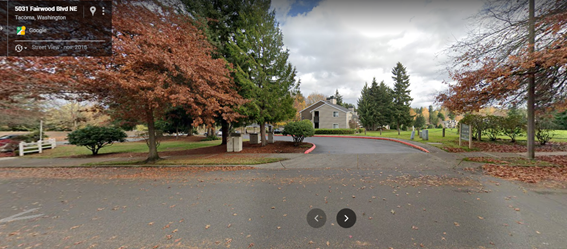

ID 286730160 -imóvel melhor ranqueado, na região de Federal Way, próximo a diversas escolas e em área tranquila.

O imóvel 2867300190 fica ao lado, mas tem seu ano de construção em 2008, por isso priorizamos o primeiro imóvel.

ID 1565930130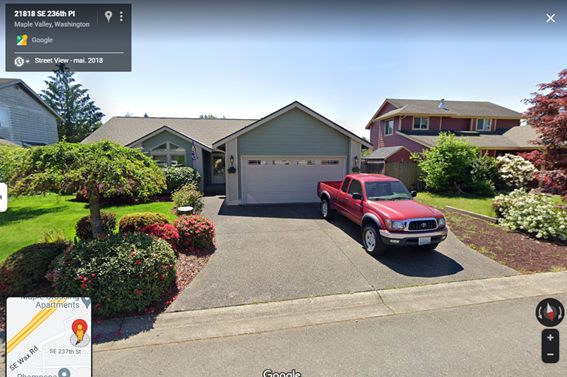

Imóvel localizado na região de Mapple Valley, próximo a Amazon DWAS, shoppings, parques e escolas, além de ser próximo a uma rodovia.

ID 5104540610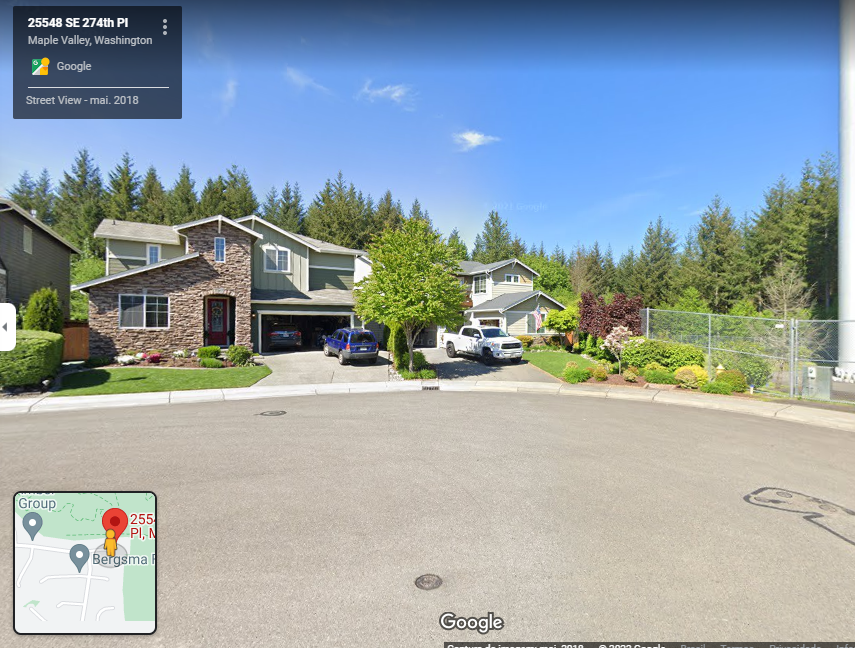

Temos 5 ocorrências nessa região e decidimos pelo imóvel mais novo, são imóveis muito parecidos e em área residencial na região de Mapple Valley.

ID 1321720140 - 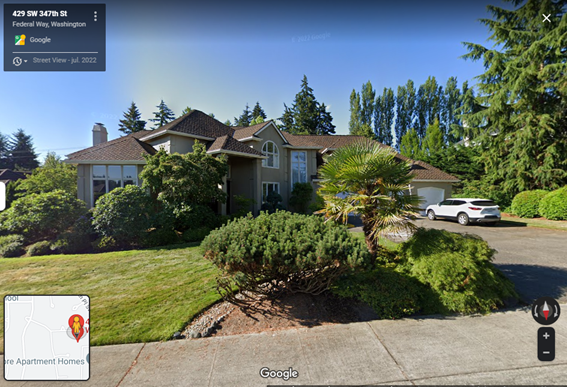

Imóvel na região de Federal Way, muito próximo a hospitais e rodovias.

ID 729805110 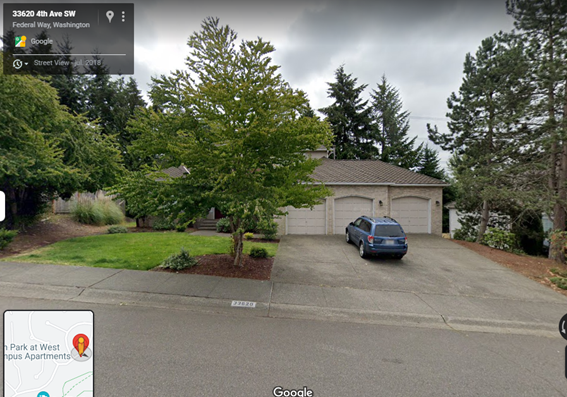

Também na região de Federal Way, próximo a universidades, escolas e rodovias.

#É importante frisar, que no execício não foi especificado Budget e nem áreas de interesse, mas após pesquisar por bairros  em Seattle, temos algumas ocorrências em zipcodes de bairros que seriam interessantes. 


#Vou deixar os zipcodes abaixo para posterior pesquisa.


In [ ]:
#Região de Redmond - sede da Microsoft
#98808,98052,98053,98073

#Região de Queen Anne - área nobre
#98119

#Região de Capitol Hill - área boêmia
#98102

#Região de Freemont - sede da Google
#98103

#Região de Ballard - área nobre
#98117

#Região de South Lake Union - sede da Amazon
#98109

#Região central
#98122

#Região da Universidade de Seattle
#98105

#Região de Ravenna - área nobre
#98115


#5 Imóveis que não devem ser comprados, são os outliers.


In [84]:
roof5_n.describe()

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
count      21613.00        21613.00 21613.00   21613.00           21613.00   
mean  4580301520.86       540088.14     3.37       1.75             192.73   
std   2876565571.31       367127.20     0.93       0.73              85.33   
min      1000102.00        75000.00     0.00       0.00              26.00   
25%   2123049194.00       321950.00     3.00       1.00             132.00   
50%   3904930410.00       450000.00     3.00       2.00             177.00   
75%   7308900445.00       645000.00     4.00       2.00             236.00   
max   9900000190.00      7700000.00    33.00       8.00            1257.00   

       terreno_m²  num_andares  beira-mar    vista  condicao_da_casa  ...  \
count    21613.00     21613.00   21613.00 21613.00          21613.00  ...   
mean      1402.97         1.45       0.01     0.23              3.41  ...   
std       3848.06         0.55       0.09     0.77              0.65  ...   
min         48.00         1.00       0.00     0.00              1.00  ...   
25%        468.00         1.00       0.00     0.00              3.00  ...   
50%        707.00         1.00       0.00     0.00              3.00  ...   
75%        992.00         2.00       0.00     0.00              4.00  ...   
max     153414.00         3.00       1.00     4.00              5.00  ...   

       area_acima_solo_m²  area_abaixo_solo_m²  ano_construção  \
count            21613.00             21613.00        21613.00   
mean               165.64                26.89         1971.01   
std                 76.94                40.92           29.37   
min                 26.00                 0.00         1900.00   
25%                110.00                 0.00         1951.00   
50%                144.00                 0.00         1975.00   
75%                205.00                52.00         1997.00   
max                874.00               447.00         2015.00   

       ano_restauração  zipcode  latitude  longitude  \
count         21613.00 21613.00  21613.00   21613.00   
mean             84.40 98077.94     47.56    -122.21   
std             401.68    53.51      0.14       0.14   
min               0.00 98001.00     47.16    -122.52   
25%               0.00 98033.00     47.47    -122.33   
50%               0.00 98065.00     47.57    -122.23   
75%               0.00 98118.00     47.68    -122.12   
max            2015.00 98199.00     47.78    -121.31   

       media_area_habitavel_região_m²  media_area_lote_região_m²  valor_m²  
count                        21613.00                   21613.00  21613.00  
mean                           184.05                    1185.71   2852.70  
std                             63.68                    2536.62   1189.87  
min                             37.00                      60.00    945.00  
25%                            138.00                     473.00   1969.00  
50%                            170.00                     707.00   2640.00  
75%                            219.00                     936.00   3439.00  
max                            576.00                   80936.00   8750.00  

[8 rows x 21 columns]

Critério adotado depois de descobrirmos o preço acima do qual é considerado outlier.

In [85]:
final_n = roof5_n.loc[(roof5_n['preço_em_dolar'] > 1129575.00 )]
final_n.shape

(1146, 22)

In [86]:
final5n = final_n.sort_values(by='preço_em_dolar', ascending=False)


In [87]:
final5n = final5n.head()
final5n

id  preço_em_dolar  quartos  banheiros  area_habitavel_m²  \
data                                                                            
2014-10-13  6762700020      7700000.00        6          8               1119   
2014-06-11  9808700762      7062500.00        5          4                932   
2014-09-19  9208900037      6885000.00        6          7                918   
2014-08-04  2470100110      5570000.00        5          5                854   
2015-04-13  8907500070      5350000.00        5          5                743   

            terreno_m²  num_andares  beira-mar  vista  condicao_da_casa  ...  \
data                                                                     ...   
2014-10-13        2564            2          0      3                 4  ...   
2014-06-11        3467            2          1      2                 3  ...   
2014-09-19        2914            2          0      4                 3  ...   
2014-08-04        3257            2          0      0                 3  ...   
2015-04-13        2228            2          0      4                 3  ...   

            area_abaixo_solo_m²  ano_construção  ano_restauração  zipcode  \
data                                                                        
2014-10-13                  323            1910             1987    98102   
2014-06-11                  219            1940             2001    98004   
2014-09-19                   95            2001                0    98039   
2014-08-04                  278            2001                0    98039   
2015-04-13                  118            2009                0    98004   

            latitude  longitude  media_area_habitavel_região_m²  \
data                                                              
2014-10-13     47.63    -122.32                             366   
2014-06-11     47.65    -122.21                             365   
2014-09-19     47.63    -122.24                             421   
2014-08-04     47.63    -122.23                             330   
2015-04-13     47.62    -122.22                             427   

            media_area_lote_região_m²  valor_m²   cidade  
data                                                      
2014-10-13                        817   6881.00  Seattle  
2014-06-11                       2364   7578.00  Seattle  
2014-09-19                       3969   7500.00  Seattle  
2014-08-04                       2261   6522.00  Seattle  
2015-04-13                       2020   7201.00  Seattle  

[5 rows x 22 columns]

Vamos plotar no gráfico para dar uma espiada onde são esses imóveis.


In [88]:
final5n_map = folium.Map(location=(47.4034, -122.167), zoom_start=10)
for index,row in final5n.iterrows(): 
  folium.Marker(location=(row['latitude'], 
                          row['longitude']), 
                popup=row['id']).add_to(final5n_map)

display(final5n_map)